<a href="https://colab.research.google.com/github/tomonari-masada/course2023-sml/blob/main/09_logistic_regression_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 課題p 20230610
 * https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

%config InlineBackend.figure_format = 'retina'

In [2]:
diabetes = pd.read_csv('/content/drive/MyDrive/data/diabetes.csv')

In [3]:
y = diabetes['Outcome']
X = diabetes.drop('Outcome', axis=1)

* この分割は変えない。

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

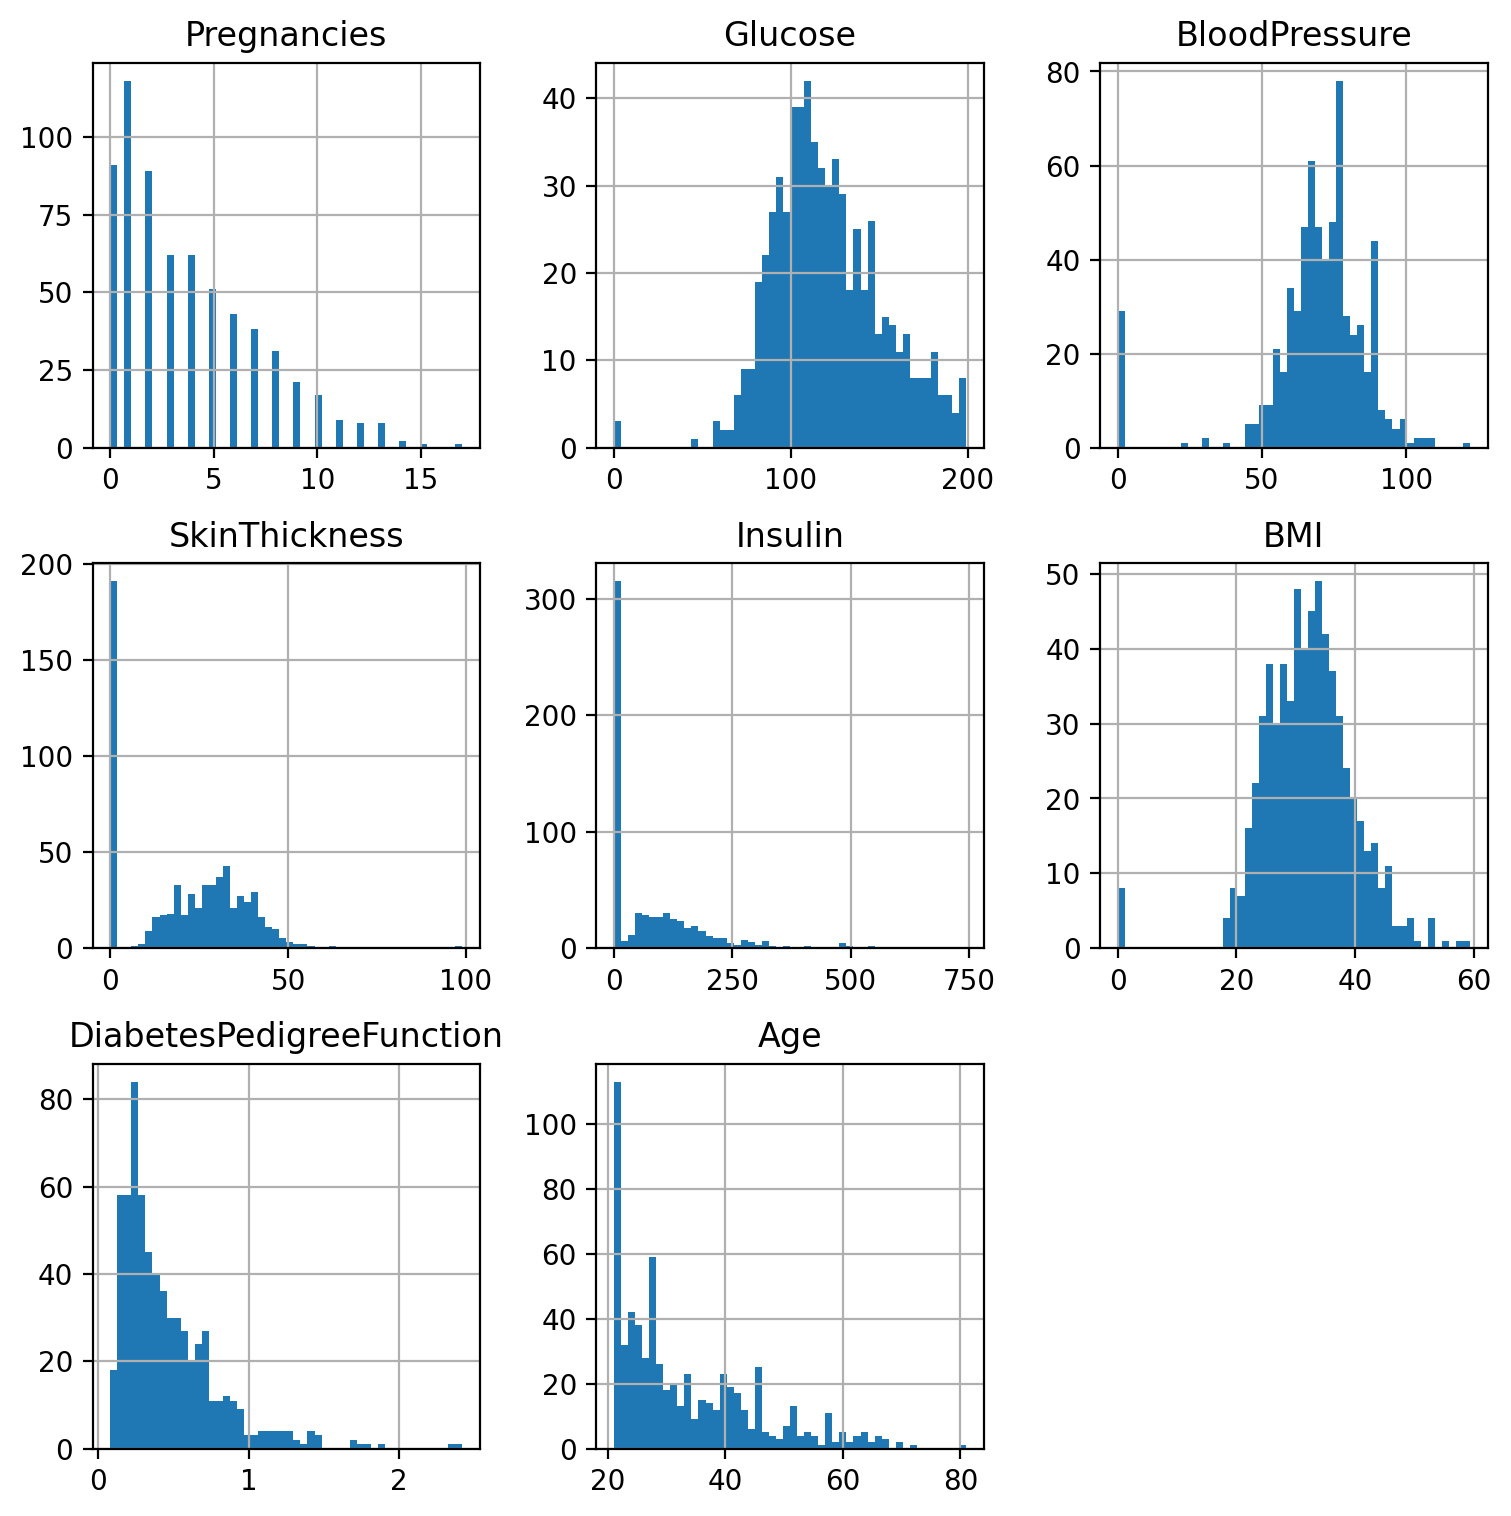

In [5]:
X_train.hist(bins=50, figsize=(9,9));

## ベースライン: チューニングなしのロジスティック回帰をテストデータで評価

In [6]:
baseline = LogisticRegression(max_iter=1000, random_state=123)
baseline.fit(X_train, y_train)
print(f'test score: {baseline.score(X_test, y_test):.4f}')
y_test_pred_proba = baseline.predict_proba(X_test)
print(f'ROC AUC: {roc_auc_score(y_test, y_test_pred_proba[:,1]):.4f}')
print(f'Average precision: {average_precision_score(y_test, y_test_pred_proba[:,1]):.4f}')

test score: 0.8103
ROC AUC: 0.8617
Average precision: 0.8186


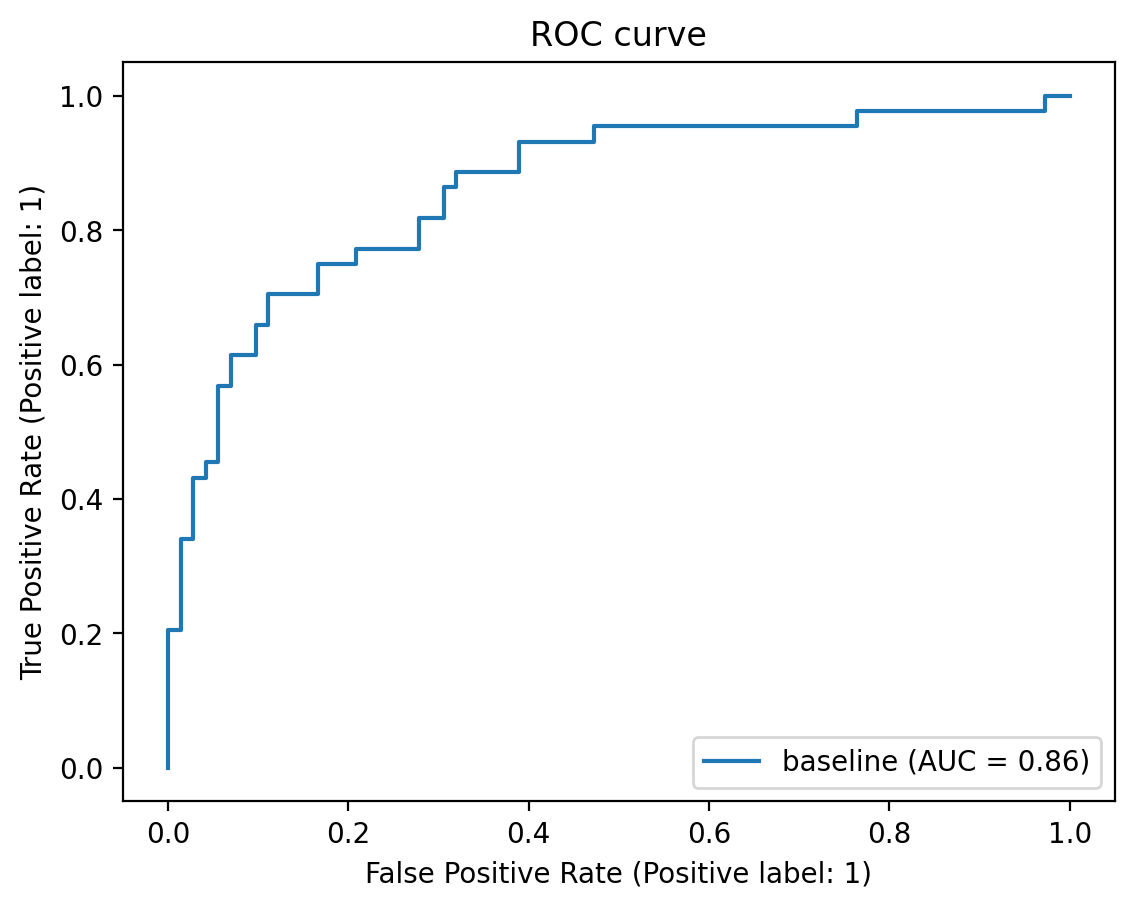

In [7]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(baseline, X_test, y_test, name="baseline", ax=ax)
ax.set_title("ROC curve");

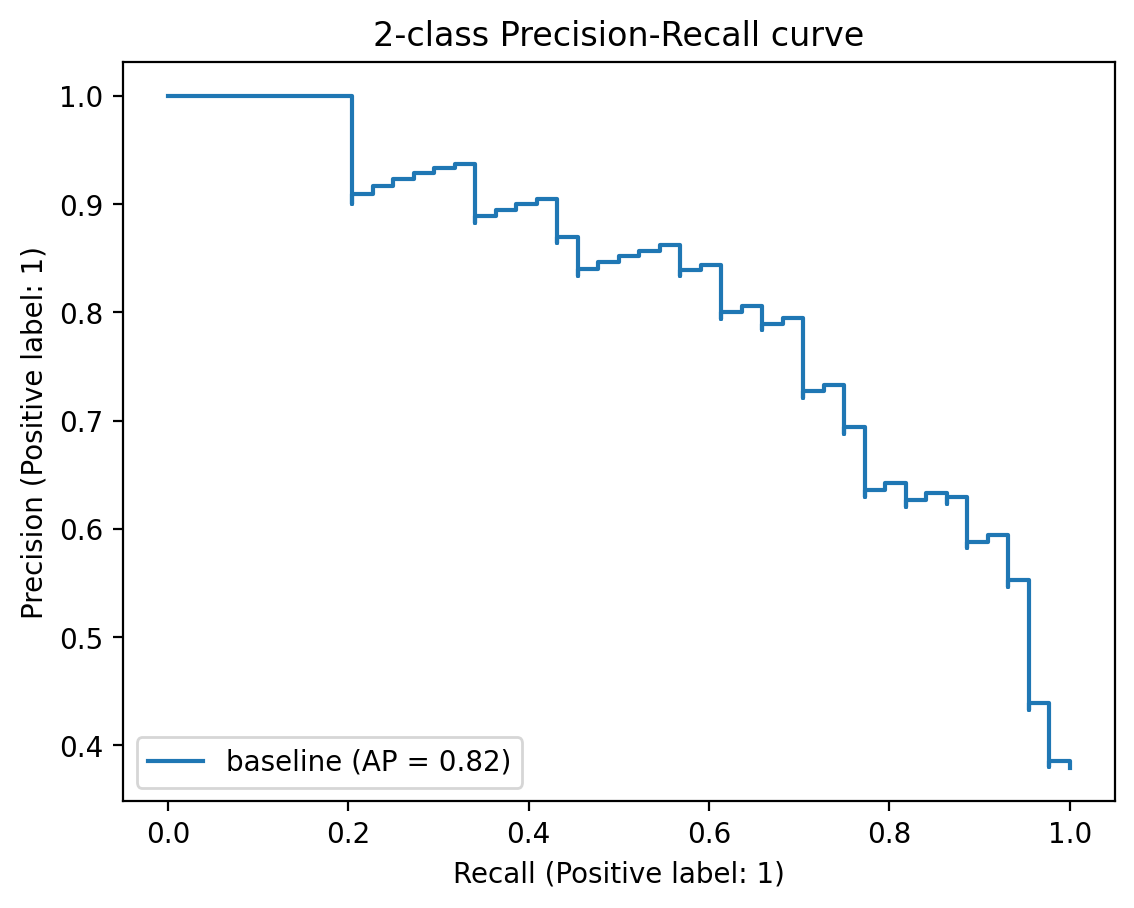

In [8]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_estimator(baseline, X_test, y_test, name="baseline", ax=ax)
ax.set_title("2-class Precision-Recall curve");

* これをベースラインとみなす。
* これより良い結果を得るべく、試行錯誤する。
* 試行錯誤した結果として辿り着いたモデルで、最後に一回、テストデータ上での評価を行う。

## グリッドサーチ＆交差検証 (1)

* Pregnanciesについては0は意味のある値なのでimputationは行わない。

In [9]:
preprocessor = ColumnTransformer(transformers=[
    ("imputer", SimpleImputer(missing_values=0, fill_value=0), ['BloodPressure', 'BMI', 'Glucose', 'SkinThickness', 'Insulin']),
     ("polynomial", PolynomialFeatures(), ['Age']),
])

In [10]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
     ("lr", LogisticRegression(max_iter=1000)),
])

In [11]:
param_grid = {
    "preprocessor__imputer__strategy": ["median", "mean", "constant"],
    "preprocessor__polynomial__degree": [1, 2],
    "lr__C": 10.0 ** np.arange(0, 5),
    "lr__penalty": [None, "l1", "l2"],
    }

In [12]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=12345)
clf = GridSearchCV(pipeline, param_grid, cv=rskf, n_jobs=-1, scoring="average_precision")
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1200 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.d

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=4, n_splits=10, random_state=12345),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('imputer',
                                                                         SimpleImputer(fill_value=0,
                                                                                       missing_values=0),
                                                                         ['BloodPressure',
                                                                          'BMI',
                                                                          'Glucose',
                                                                          'SkinThickness',
                                                                          'Insulin']),
                                                                        ('polynomial',
                                                                         PolynomialFeatures(),
                                                                         ['Age'])])),
                                       ('lr',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'lr__C': array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
                         'lr__penalty': [None, 'l1', 'l2'],
                         'preprocessor__imputer__strategy': ['median', 'mean',
                                                             'constant'],
                         'preprocessor__polynomial__degree': [1, 2]},
             scoring='average_precision')

In [13]:
pd.DataFrame.from_dict(clf.cv_results_).sort_values(by=["rank_test_score"]).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__penalty,param_preprocessor__imputer__strategy,param_preprocessor__polynomial__degree,params,split0_test_score,...,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,mean_test_score,std_test_score,rank_test_score
33,0.053670,0.006951,0.007534,0.000529,10.0,l2,mean,2,"{'lr__C': 10.0, 'lr__penalty': 'l2', 'preproce...",0.840434,...,0.764170,0.798560,0.742319,0.768537,0.724107,0.703831,0.812343,0.742903,0.064955,1
31,0.054090,0.012158,0.007476,0.000645,10.0,l2,median,2,"{'lr__C': 10.0, 'lr__penalty': 'l2', 'preproce...",0.833805,...,0.764170,0.805717,0.745625,0.768537,0.732179,0.704228,0.813088,0.742795,0.064527,2
49,0.055111,0.009039,0.007728,0.001584,100.0,l2,median,2,"{'lr__C': 100.0, 'lr__penalty': 'l2', 'preproc...",0.835076,...,0.764816,0.805717,0.746279,0.766790,0.732179,0.703668,0.810839,0.741778,0.064589,3


## テストデータで最終評価

In [14]:
best_pipeline = clf.best_estimator_

In [15]:
best_pipeline.fit(X_train, y_train)
print(f'test score: {best_pipeline.score(X_test, y_test):.4f}')
y_test_pred_proba = best_pipeline.predict_proba(X_test)
print(f'ROC AUC: {roc_auc_score(y_test, y_test_pred_proba[:,1]):.4f}')
print(f'Average precision: {average_precision_score(y_test, y_test_pred_proba[:,1]):.4f}')

test score: 0.7672
ROC AUC: 0.8671
Average precision: 0.7867


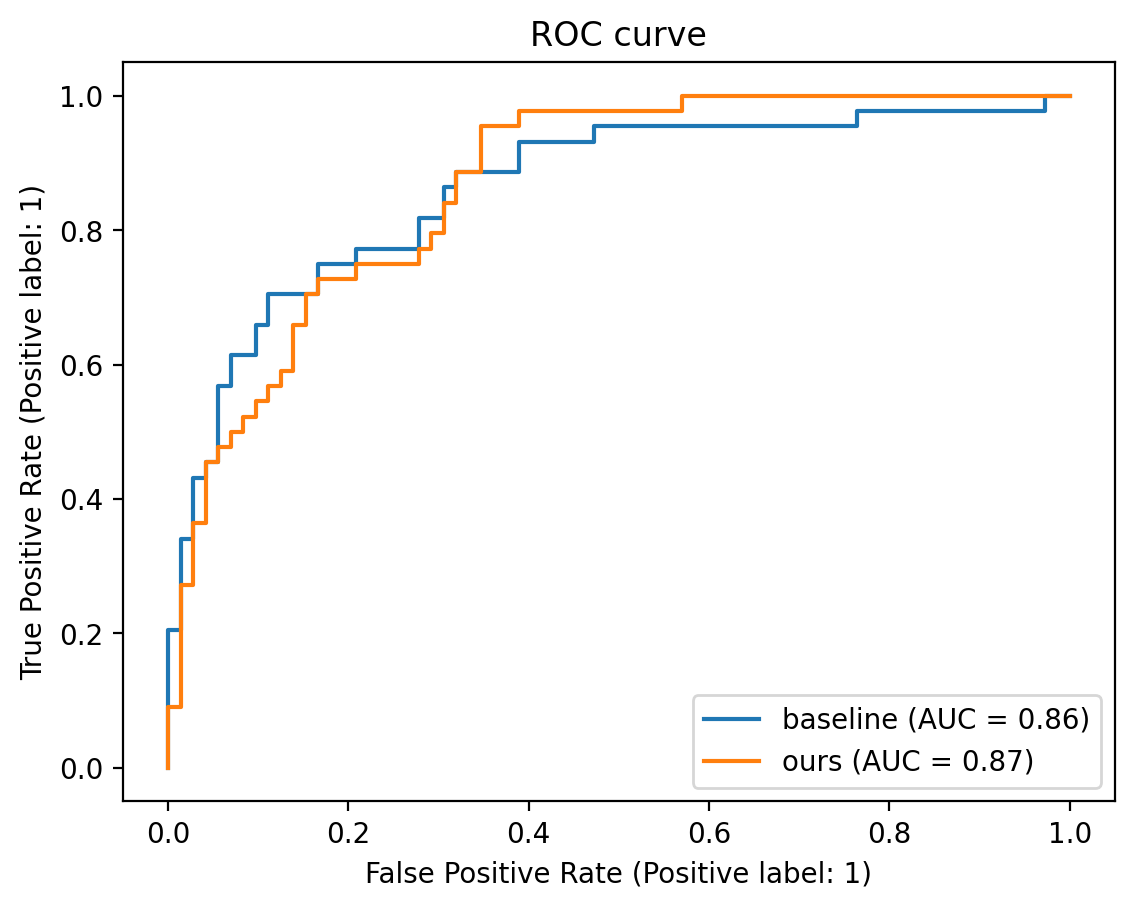

In [16]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(baseline, X_test, y_test, name="baseline", ax=ax)
RocCurveDisplay.from_estimator(best_pipeline, X_test, y_test, name="ours", ax=ax)
ax.set_title("ROC curve");

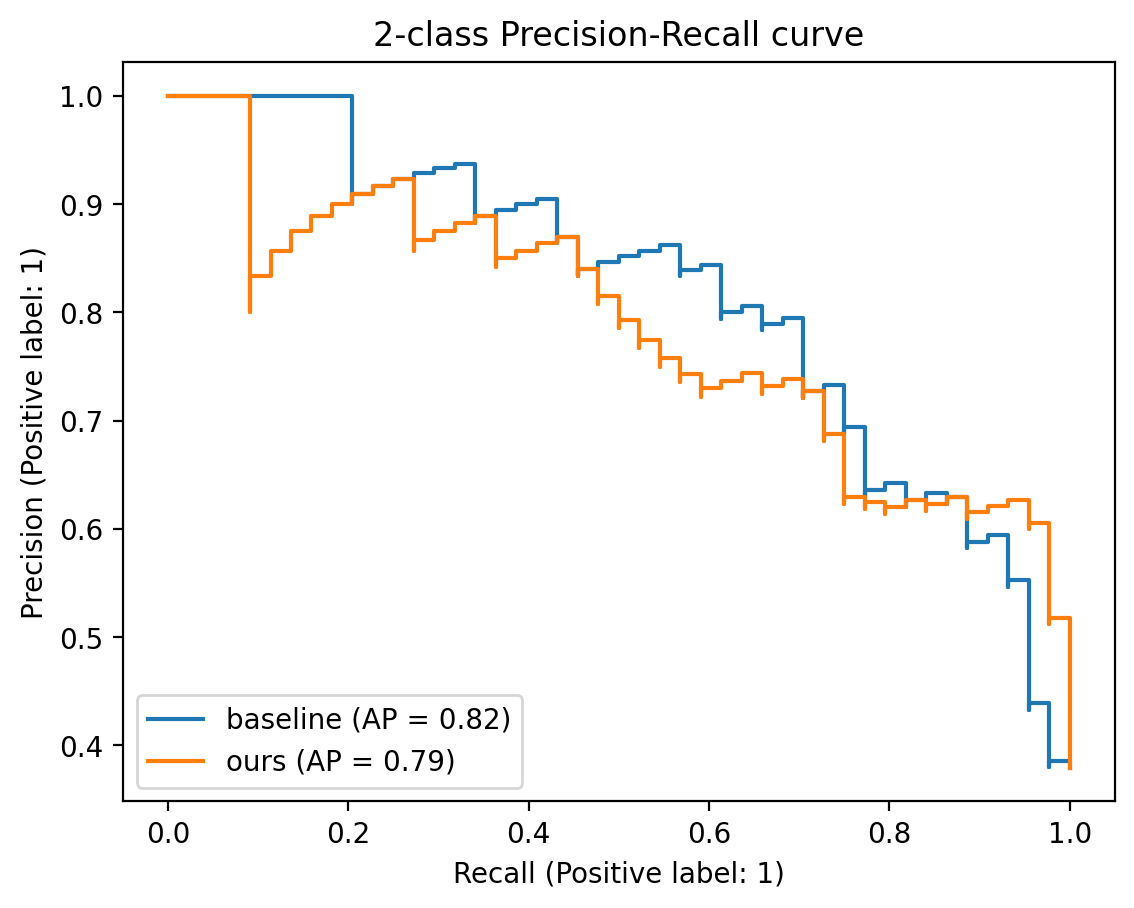

In [17]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_estimator(baseline, X_test, y_test, name="baseline", ax=ax)
PrecisionRecallDisplay.from_estimator(best_pipeline, X_test, y_test, name="ours", ax=ax)
ax.set_title("2-class Precision-Recall curve");